In [1]:
import os
import numpy as np
import pandas as pd
import xsimlab as xs
import xsimlab.dot as dot
import vmlab

# Modularization

- inspecting the models processes
- creating a customized process (Harvest by a fruit's sucrose content) based on an existing process (Harvest by a fruit's temperature sum)
- replace the default process with the customized one

In [2]:
from vmlab.models import *

### Customized visualization of process dependencies

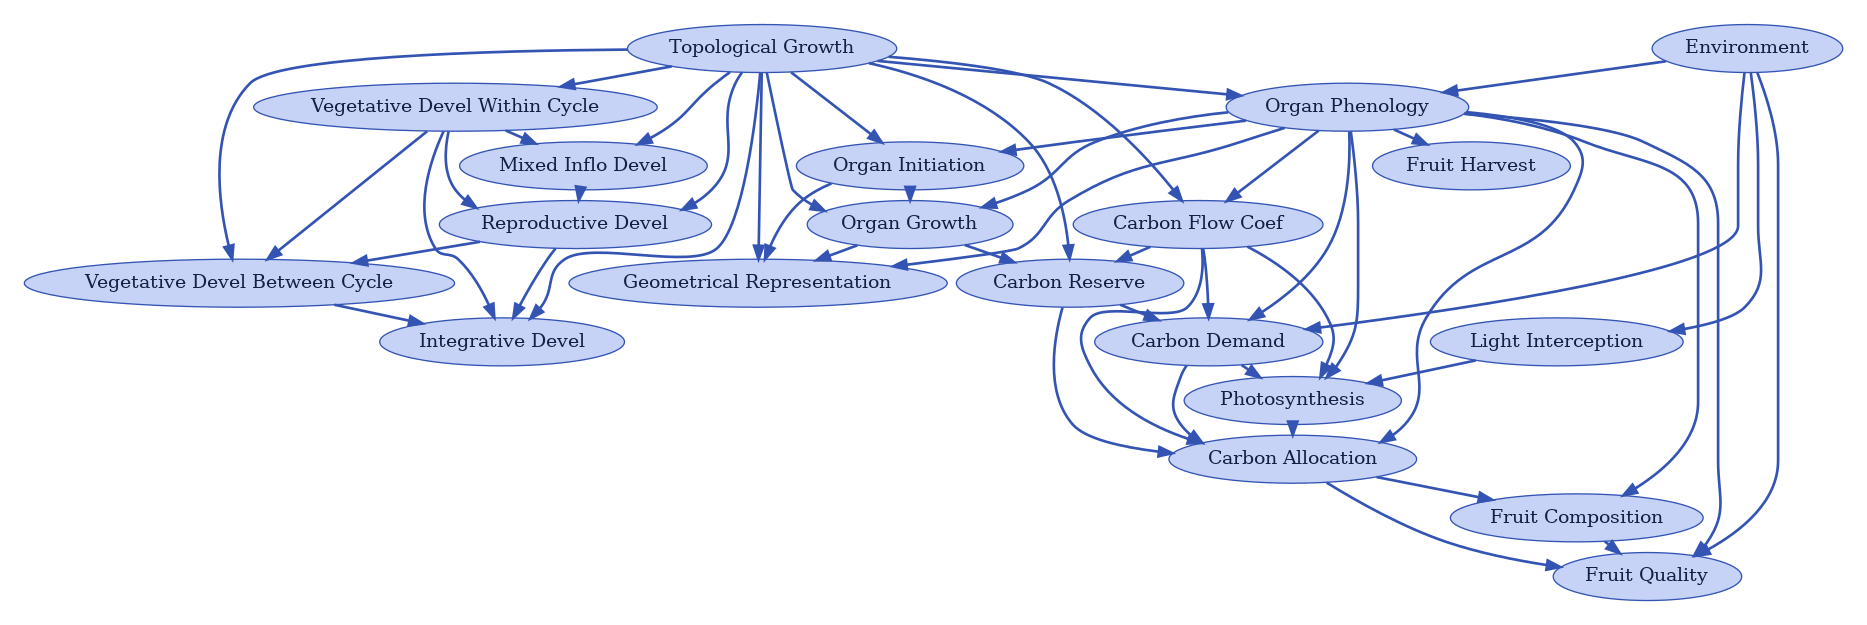

In [3]:
dot.dot_graph(longname_model(vmango), 
              rankdir='TB',
              graph_attr = {'margin':'0.2', 'nodesep':'0.1', 'ranksep':'0.1'})

### Inspecting the 'Harvest' process

In [4]:
xs.process_info(vmango.harvest)

<Harvest  (xsimlab process)>
Variables:
    parameter_file_path     [in]
    parameters             [out]
    nb_gu                   [in] <--- <unknown>.<unknown>
    fruit_growth_tts        [in] <--- Phenology.fruit_growth_tts
    nb_fruit                [in] <--- Phenology.nb_fruit
    ripeness_index       [inout] ('GU',) ripening index
    harvested            [inout] ('GU',) Just a helper to set those...
    nb_fruit_harvested   [inout] ('GU',) Number of fruits harvested
Simulation stages:
    initialize
    run_step


### Inspecting the 'Fruit Quality' process

In [5]:
xs.process_info(vmango.fruit_quality)

<FruitQuality  (xsimlab process)>
Variables:
    parameter_file_path        [in]
    parameters                [out]
    nb_gu                      [in] <--- <unknown>.<unknown>
    TM_day                     [in] <--- Environment.TM_day
    GR_day                     [in] <--- Environment.GR_day
    RH_day                     [in] <--- Environment.RH_day
    nmol_solutes               [in] <--- FruitComposition.nmol_solutes
    mass_suc                   [in] <--- FruitComposition.mass_suc
    mass_glc                   [in] <--- FruitComposition.mass_glc
    mass_frc                   [in] <--- FruitComposition.mass_frc
    mass_sta                   [in] <--- FruitComposition.mass_sta
    mass_mal                   [in] <--- FruitComposition.mass_mal
    mass_cit                   [in] <--- FruitComposition.mass_cit
    fruit_growth_tts           [in] <--- Phenology.fruit_growth_tts
    nb_fruit                   [in] <--- Phenology.nb_fruit
    fruited                    [in] <--- 

## Uncomment the next line and excecute it to load the implementation of the 'Harvest' process. Then we can inspect, copy and adjust it

In [6]:
#%load -s Harvest $vmlab.processes.harvest.__file__

# Create a new Harvest Process inheriting from 'Harvest'

In [7]:
from vmlab.processes.harvest import Harvest

@xs.process
class CustomHarvest(Harvest):
    
    # import a variable from another process
    fruit_quality = xs.group_dict('fruit_quality')
    # create a new 'in' variable. Value must be supplied in the setup
    sucrose_threshold = xs.variable(intent='in')

    def initialize(self):
        # initialize the base 'Harvest' class
        super().initialize()

    def run_step(self):
        sucrose = self.fruit_quality[('fruit_quality', 'sucrose')]
        self.harvested[:] = 0.
        growing = self.fruit_growth_tts > 0.
        sucrose_thresh_fruit_ripe = self.parameters.sucrose_thresh_fruit_ripe
        self.ripeness_index[growing] = np.where(
            self.ripeness_index[growing] < (sucrose[growing] / self.sucrose_threshold),
            np.minimum(1., sucrose[growing] / self.sucrose_threshold),
            self.ripeness_index[growing]
        )
        self.harvested[(self.nb_fruit_harvested == 0) & (self.ripeness_index == 1.)] = 1.
        self.nb_fruit_harvested[self.harvested == 1.] = self.nb_fruit[self.harvested == 1.]
        self.nb_fruit_harvested[self.harvested == 1.] = self.nb_fruit[self.harvested == 1.]

## Replace the default 'Harvest' with out new 'CustomHarvest' process based on 'sucrose' variable from the 'FruitQuality' process

In [8]:
custom_model = vmango.update_processes({'harvest': CustomHarvest}).drop_processes('geometry')
xs.process_info(custom_model.harvest)

<CustomHarvest  (xsimlab process)>
Variables:
    parameter_file_path     [in]
    parameters             [out]
    nb_gu                   [in] <--- <unknown>.<unknown>
    fruit_growth_tts        [in] <--- Phenology.fruit_growth_tts
    nb_fruit                [in] <--- Phenology.nb_fruit
    ripeness_index       [inout] ('GU',) ripening index
    harvested            [inout] ('GU',) Just a helper to set those...
    nb_fruit_harvested   [inout] ('GU',) Number of fruits harvested
    fruit_quality           [in] <--- group 'fruit_quality'
    sucrose_threshold       [in]
Simulation stages:
    initialize
    run_step


## Creating a setup and providing a value for 'sucrose_threshold' 

In [9]:
setup = vmlab.create_setup(
    model=custom_model,
    start_date='2003-06-01',
    end_date='2005-06-01',
    setup_toml='vmango.toml',
    input_vars={
        'harvest__sucrose_threshold': 0.1
    },
    output_vars={
        'harvest': {
            'ripeness_index': 'day',
        },
        'fruit_quality': {
            'sucrose': 'day'
        },
        'phenology': {
            'nb_fruit': 'day'
        }
    }
)

In [10]:
ds = vmlab.run(setup, custom_model)
ds

             0% | initialize 

<xarray.Dataset>
Dimensions:                  (GU: 1773, day: 732)
Coordinates:
  * GU                       (GU) int32 0 1 2 3 4 5 ... 1768 1769 1770 1771 1772
  * day                      (day) datetime64[ns] 2003-06-01 ... 2005-06-01
Data variables:
    fruit_quality__sucrose   (day, GU) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    harvest__ripeness_index  (day, GU) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    phenology__nb_fruit      (day, GU) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

## Plotting the 'sucrose' content for the first 12 GUs

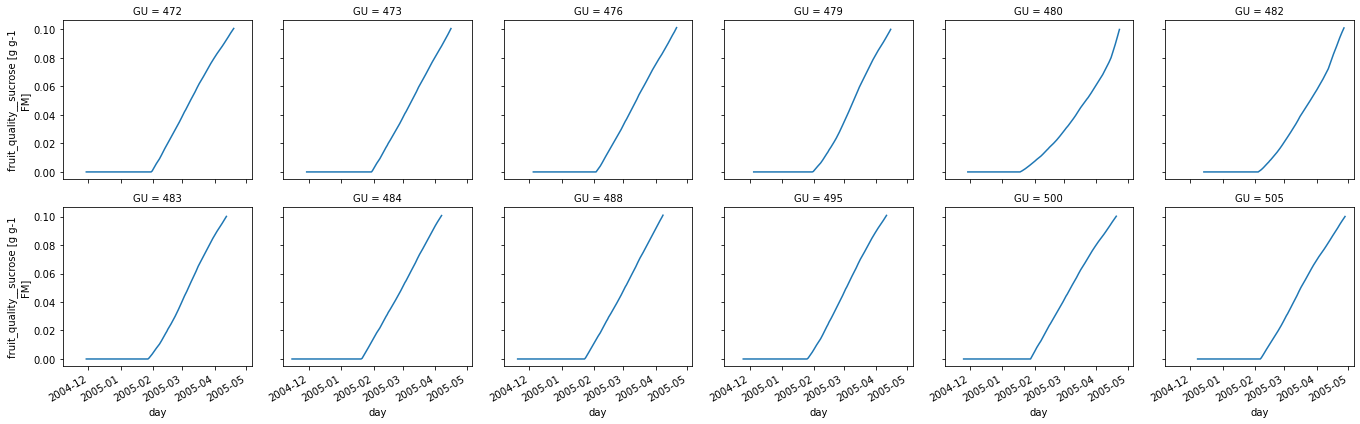

In [11]:
ds.fruit_quality__sucrose.where(ds.phenology__nb_fruit > 0, drop=True)[:, 0:12].plot(col='GU', col_wrap=6)